### Training on real data

Here we train on real publicly available data.
How to obtain the dataset is described in the the DataPrep notebook.

We introduce two additional features that help improving fits on real data.

For this example a GPU is required to train the model in reasonable time.

In [1]:
import sys
import os
sys.path.append("engine/")
sys.path.append("funcs/")
sys.setrecursionlimit(10000)

import theano.gpuarray
theano.gpuarray.use('cuda2')

import theano
import theano.tensor as T
from theano import config
import numpy as np
import pickle
import copy
import time
from itertools import *

from matplotlib import pyplot as plt
from matplotlib import gridspec
%matplotlib inline

from VIMCO_alpha import *

Using cuDNN version 6021 on context None
Preallocating 10986/12207 Mb (0.900000) on cuda2
Mapped name None to device cuda2: GeForce GTX TITAN X (0000:04:00.0)


In [2]:
home_folder = os.getenv('HOME')+'/Mackebox/Artur/WorkDB/deepspike/'

buffers = [100,40]
timebins_eval = 250
timebins = timebins_eval + sum(buffers)

samples = 64
lr = 5e-4
batch_size = 12

rng = np.random.RandomState(1)
lasagne.random.set_rng(rng)

Data preprocessing is performed in the G6s_prep notebook.

In [3]:
with open('gc6s_prepped.pkl', 'rb') as f:
    data = pickle.load(f)
    
n_cells = 9

Traces_train = data['traces'][:n_cells]
Spikes_train = data['spikes'][:n_cells]

fps = data['fps'][:n_cells]
spikefps = data['spike_fps']

sv_Traces,sv_Spikes = data_chop(timebins, Traces_train, Spikes_train, [],fps, spikefps,75, fb=False)
sv_Spikes = [[] for _ in range(n_cells)]
test_tr_us, test_sp_us = data_chop(1798, Traces_train,  Spikes_train, None, fps, spikefps,75,fb=False)

We use the ML_phys generative model described in our paper.
delta_t is the constant bin size, and is not trained. 

    C_(t) = s + exp(δ/τ) * C_(t-1)
    D_(t) = minimum(1/softplus(γ),(D_(t-1) * maximum(0,1 - δ/softplus(kappa)*(1+softplus(γ)*((softplus(c0)+C_(t)) ^ η - softplus(c0) ^ η))) + δ/softplus(kappa)*((softplus(c0)+C_(t)) ^ η - softplus(c0) ^ η)))
    F_(t) = softplus(α) * D_(t) + β + sigmoid(σ)

Fitting the generative model parameters is a major challenge, especially for real data where we don't have access to the true underlying generative model.
One problem that often arises is that the generative model converges to a solution with very small amplitudes, this way the model can fit everything (also baseline fluctuations and noise) using large numbers of spikes. 
We found two measures that help to alleviate the problem. They are not part of the paper and further improve upon it's results.

### Parameter inference:

The most critical parameter, and also the one most variable from cell to cell is the amplitude of the response to a spike, here parametrized by alpha.

Here the recognition model infers the amplitude based on the currently observed fluroscence trace. More specifically a sample is taken from a normal distribution,
where the mean and variance are the output of the recognition model. This sample is added to the initial alpha value.

This way, during training a range of alpha values is available from which the VIMCO algorithm chooses the best ones to calculate the gradients. This stabilizes the training.

### Baseline estimation:

Real data includes fluorescence transients that are not cause by spiking activity. However our model can only explain transients using spikes.
Therefore baseline fluctuations not only induce flase positives at test time, but also degrade the quality of the training.

During training at each iteration we calculate an estimate of baseline fluctions by performing a regularized least squares regression on the residual (trace - reconstruction). 
Thise estimate of the baseline is substraced from the trace, and the loglikelihood of the reconstruction is calculated based on this 'cleaned' trace.

This way the recognition model learns to ignore baseline fluctuations without explicitly estimating them.

In [4]:
init_params = {'alpha': -1.15, 'beta': -0.0, 'c0': 0.83, 'delta_t': 1/75, 'eta': 1.84, 'gamma': -4.8, 'kappa': -2.62, 'sigma': -3.5, 'tau': 1.87}
inf_params = ['alpha']

recDict = set_rec_net([35,25,25,20,15],[51,31,21,13,11], FB = True, AR = True, n_rnn_units = 128, n_genparams=1, p_sigma = 0.3)
model = VIMCO(init_params, inf_params, ML_phys, recDict, GRUX_BernoulliRecognition,batch_size=batch_size, n_samples = samples, n_cells = n_cells, rng = rng, filename = 'gc6_model')

model.true_params = [None for _ in range(n_cells)]

model.gen_lr_fac = 3
model.lr_decay = np.array(0.995, dtype=theano.config.floatX)
model.buffers = buffers
model.facs = [3]
model.mrec.pz = 0.001
model.gradnorm_clip = 0.02
model.conc_cache = False
model.gradnorm_tot = True
model.resample = 75
model.mgen.fixed_gen = False
model.lstsq_bl = True  # Whether to use a baseline estimate during training
model.bl_lambda = 5 # Regularization parameter for the baseline regression
model.validation_score = 'synchro_0'

model.eval_sets = [{'traces':test_tr_us, 'spikes':test_sp_us, 'eval_T':1798, 'eval_rep': 5, 'test_gen':True}]

For real data we don't have access to the ground truth generative model parameters, so the MSE variables are less useful.

In [5]:
model.fit(sv_Traces,sv_Spikes,max_epochs= 100, learning_rate = lr, print_freq=100)

/usr/local/lib/python3.5/dist-packages/theano/tensor/basic.py:5262: UserWarning: flatten outdim parameter is deprecated, use ndim instead.
  "flatten outdim parameter is deprecated, use ndim instead.")


Corr. Train: 0.617 Synchro: 0.345 || MSE Pred./Truth: 0.402 0.539 || Cost: -34.277 || Factor: 0.884 || Time upd./Eval.: 818.0 ms 3.4 s || BatchNr.: 100
Corr. Train: 0.685 Synchro: 0.380 || MSE Pred./Truth: 0.683 0.488 || Cost: -40.584 || Factor: 1.803 || Time upd./Eval.: 854.4 ms 3.5 s || BatchNr.: 200
Corr. Train: 0.693 Synchro: 0.439 || MSE Pred./Truth: 0.585 0.506 || Cost: -28.408 || Factor: 1.520 || Time upd./Eval.: 857.2 ms 3.5 s || BatchNr.: 300
Corr. Train: 0.644 Synchro: 0.422 || MSE Pred./Truth: 0.387 0.462 || Cost: -11.726 || Factor: 1.647 || Time upd./Eval.: 867.9 ms 2.1 s || BatchNr.: 400
Corr. Train: 0.661 Synchro: 0.456 || MSE Pred./Truth: 0.663 0.534 || Cost: -24.461 || Factor: 1.308 || Time upd./Eval.: 822.1 ms 4.4 s || BatchNr.: 500
Corr. Train: 0.728 Synchro: 0.536 || MSE Pred./Truth: 0.635 0.545 || Cost: -3.638 || Factor: 1.113 || Time upd./Eval.: 819.7 ms 3.6 s || BatchNr.: 600
Corr. Train: 0.686 Synchro: 0.503 || MSE Pred./Truth: 0.427 0.473 || Cost: -5.906 || Fact

Corr. Train: 0.734 Synchro: 0.634 || MSE Pred./Truth: 0.916 0.948 || Cost: 1.695 || Factor: 1.255 || Time upd./Eval.: 830.4 ms 2.0 s || BatchNr.: 5600
Corr. Train: 0.740 Synchro: 0.613 || MSE Pred./Truth: 1.017 1.040 || Cost: 3.775 || Factor: 1.212 || Time upd./Eval.: 853.1 ms 2.0 s || BatchNr.: 5700
Corr. Train: 0.716 Synchro: 0.606 || MSE Pred./Truth: 0.516 0.565 || Cost: -4.395 || Factor: 1.486 || Time upd./Eval.: 865.2 ms 2.0 s || BatchNr.: 5800
Corr. Train: 0.748 Synchro: 0.636 || MSE Pred./Truth: 0.866 0.834 || Cost: 4.157 || Factor: 1.218 || Time upd./Eval.: 871.8 ms 2.1 s || BatchNr.: 5900
Corr. Train: 0.745 Synchro: 0.657 || MSE Pred./Truth: 0.922 0.862 || Cost: 4.710 || Factor: 1.168 || Time upd./Eval.: 810.3 ms 4.8 s || BatchNr.: 6000
Corr. Train: 0.769 Synchro: 0.637 || MSE Pred./Truth: 0.389 0.478 || Cost: 4.031 || Factor: 1.212 || Time upd./Eval.: 915.3 ms 2.1 s || BatchNr.: 6100
Corr. Train: 0.745 Synchro: 0.601 || MSE Pred./Truth: 0.600 0.518 || Cost: 4.332 || Factor: 1

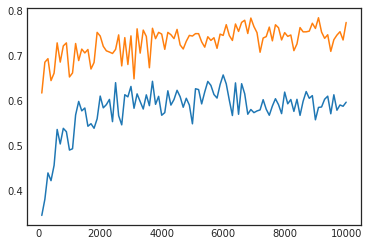

In [9]:
from plot_funcs import *
plot_od(model.col_dict['synchro_0'])
plot_od(model.col_dict['corr_0'])

Zoomed in snippet. Reconstructions based on the true spike trains is shown for a number of sampled alpha values.
Thre reconstruction based on the inferred spike train (Dark blue) is calculated using the mean alpha value.

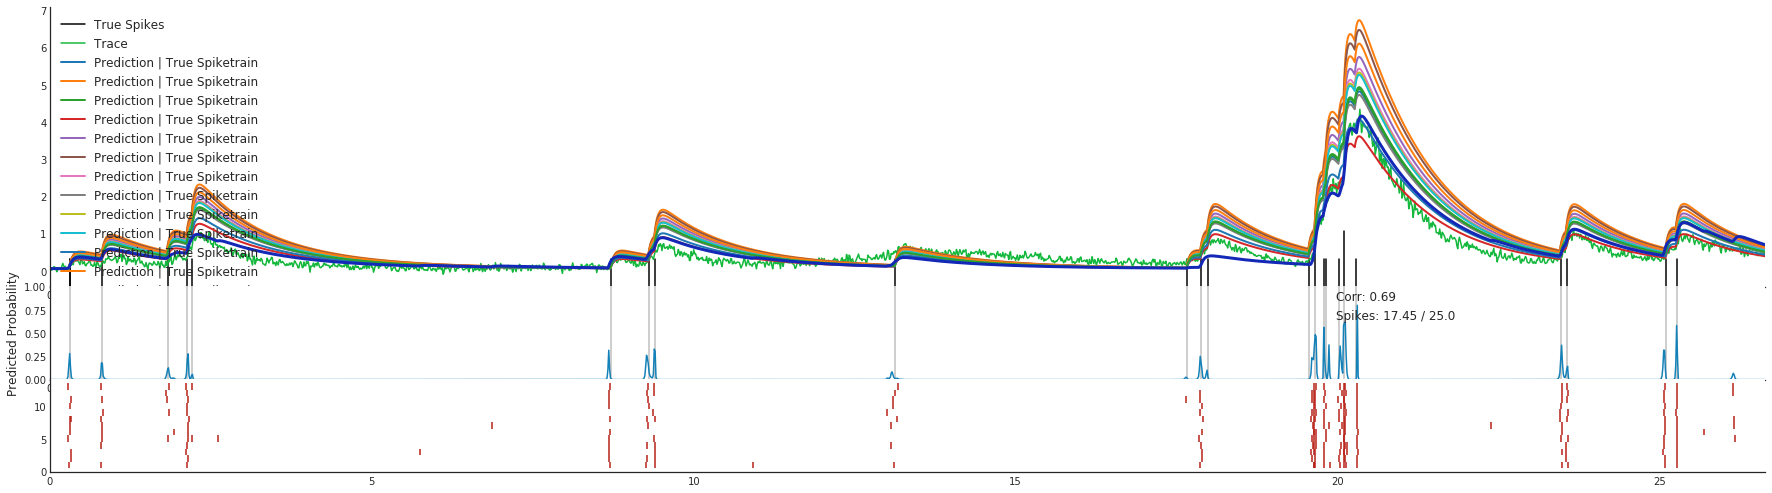

In [7]:
plot_preds_bl(model,data,cell=1,trace=0,figsize=(35,7),ts=[10000,12000])

Results on all traces.

Cell  0


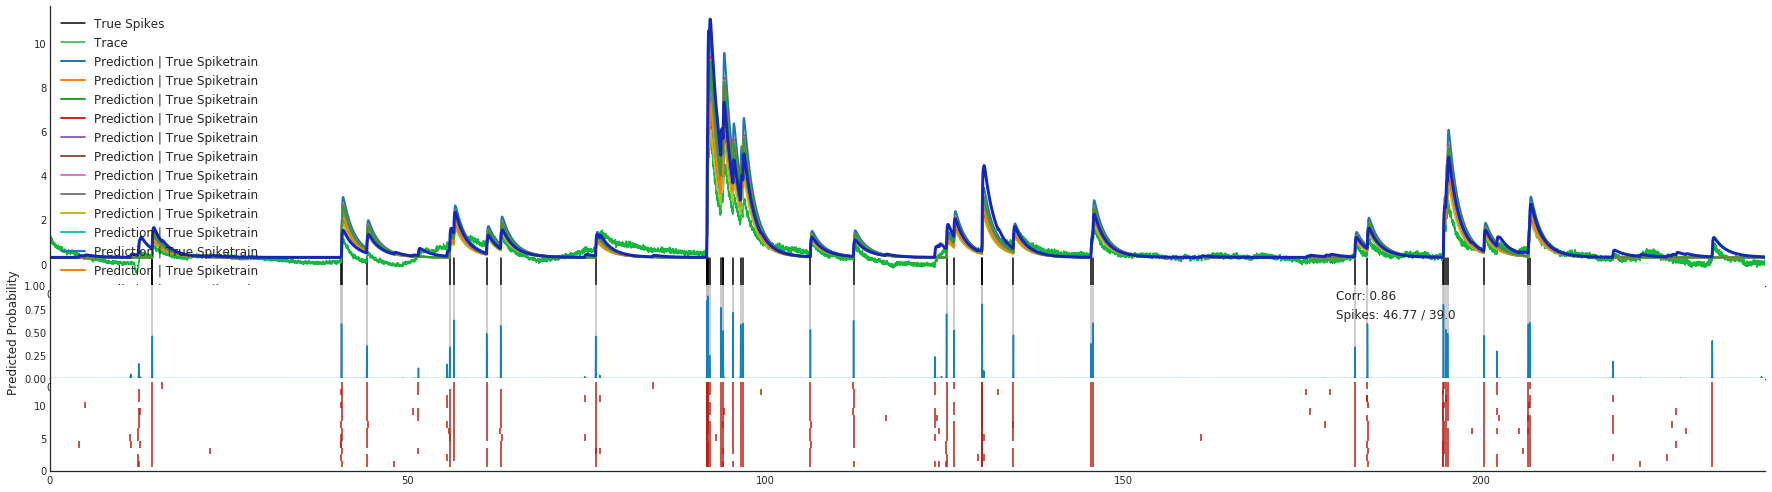

Cell  1


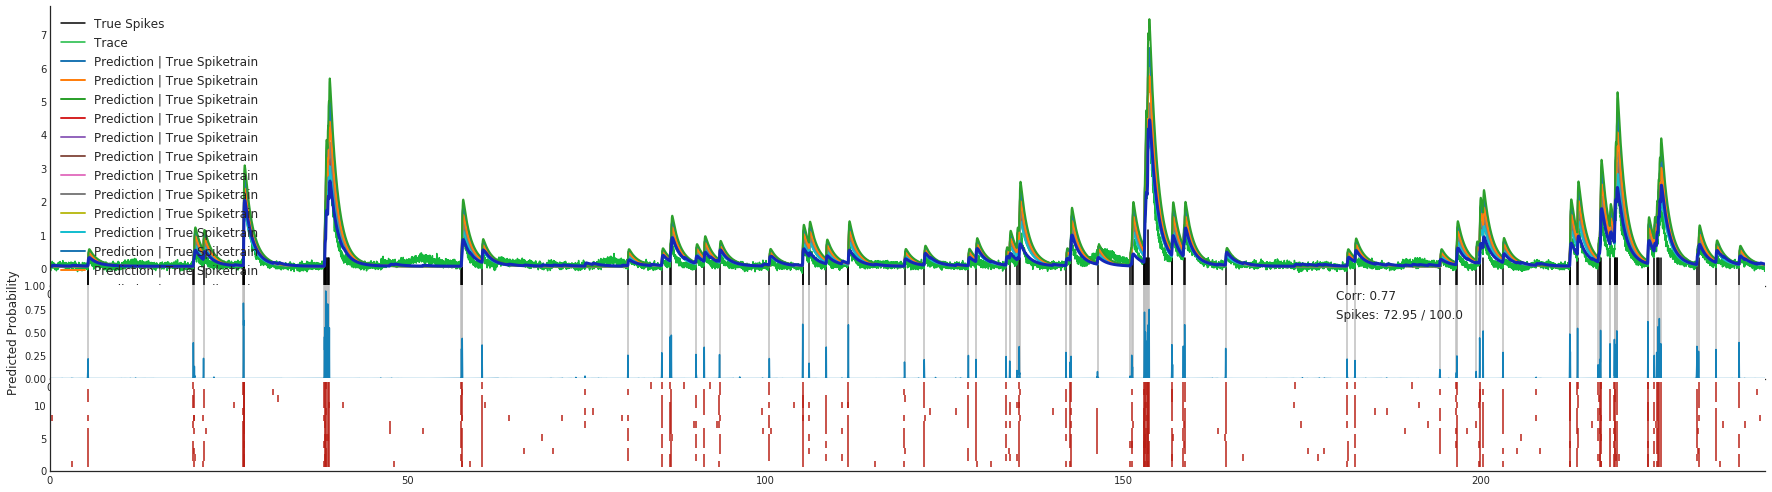

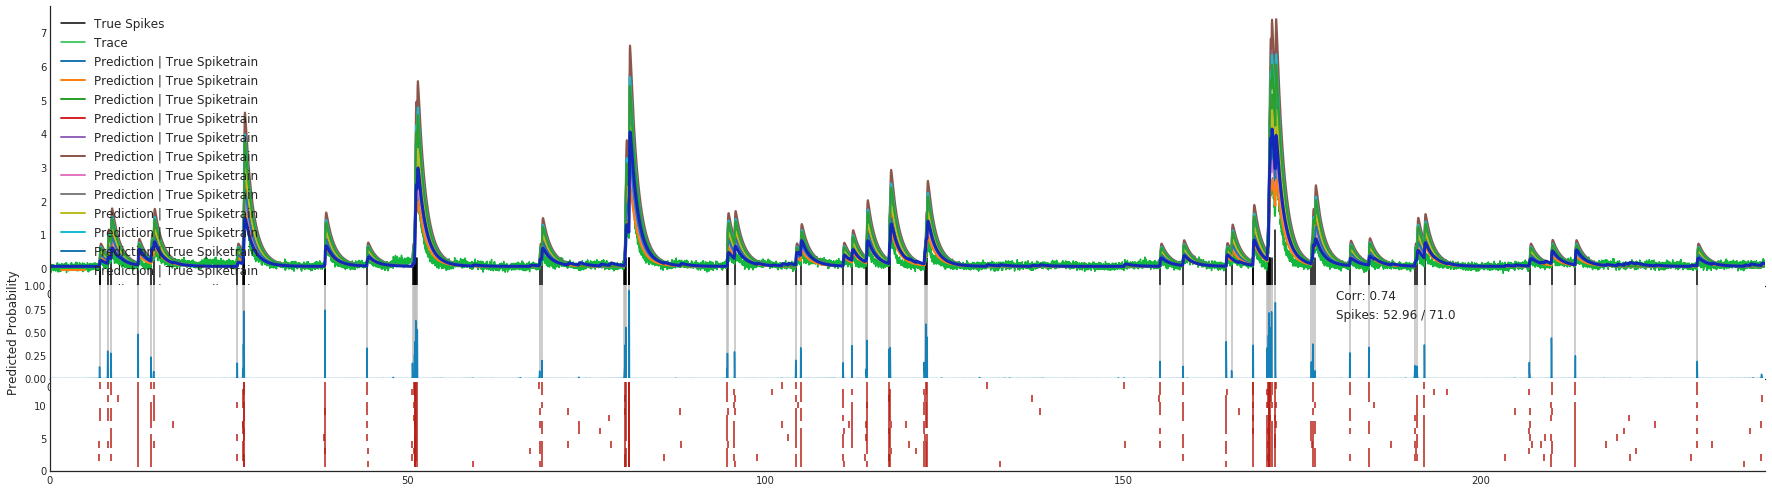

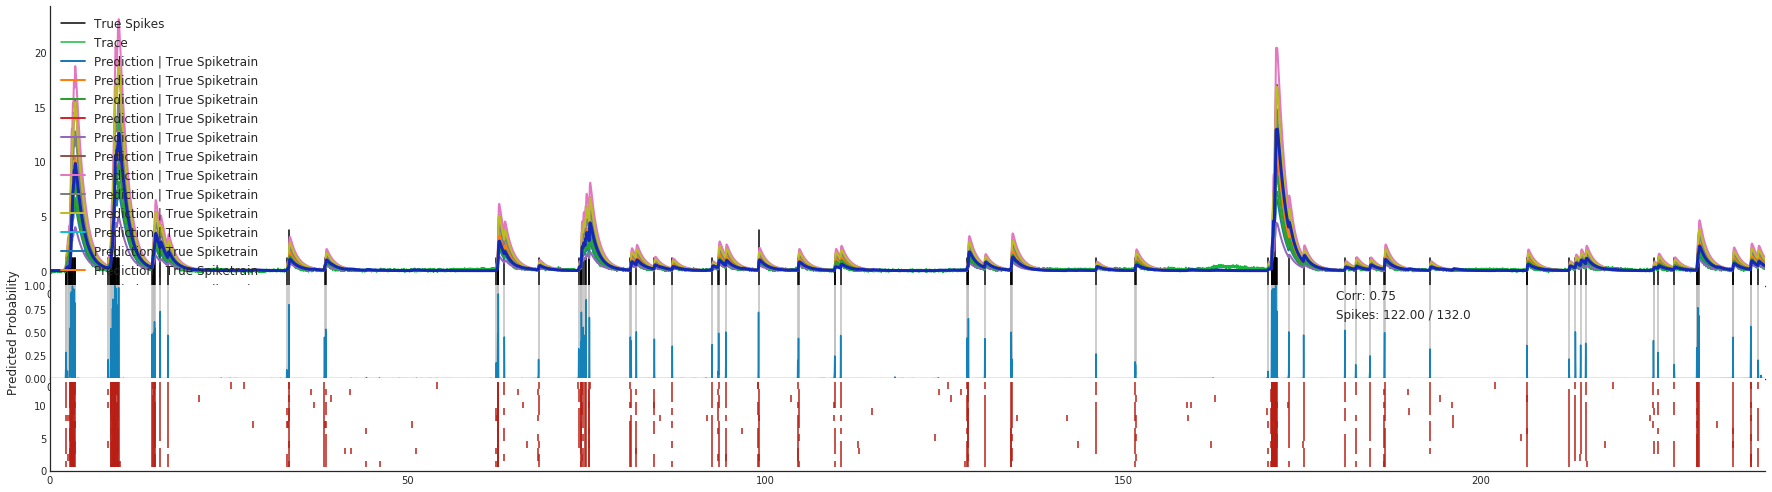

Cell  2


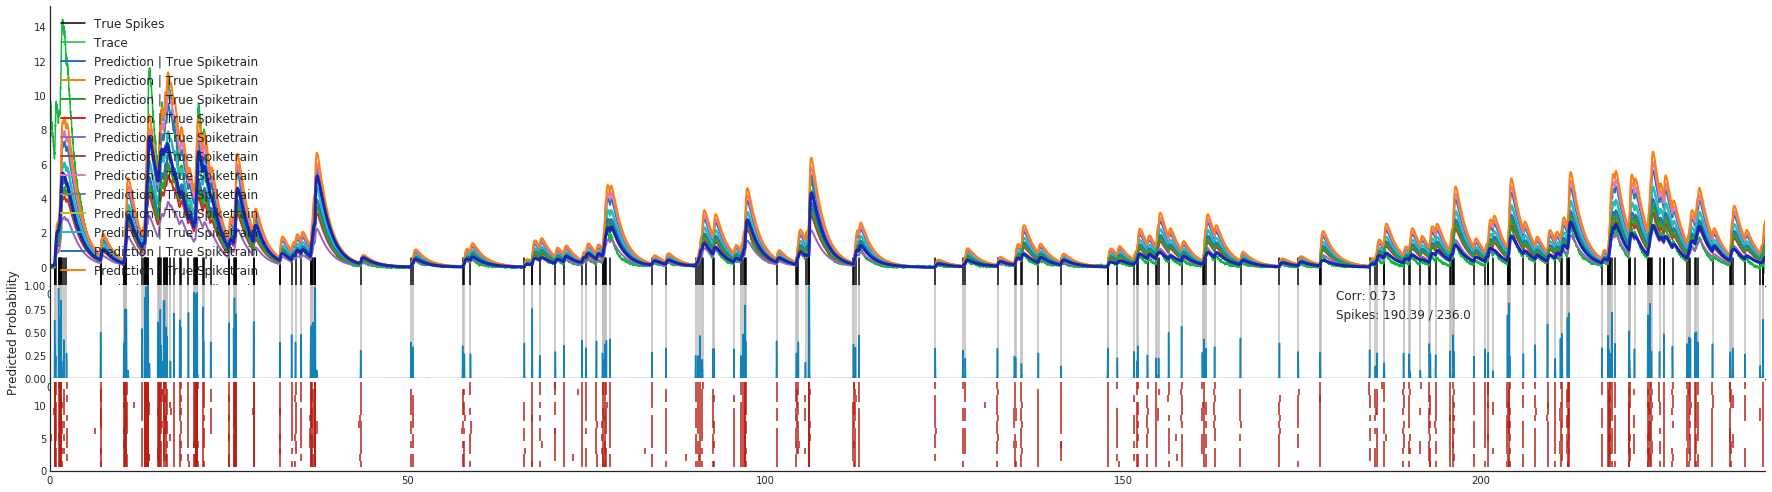

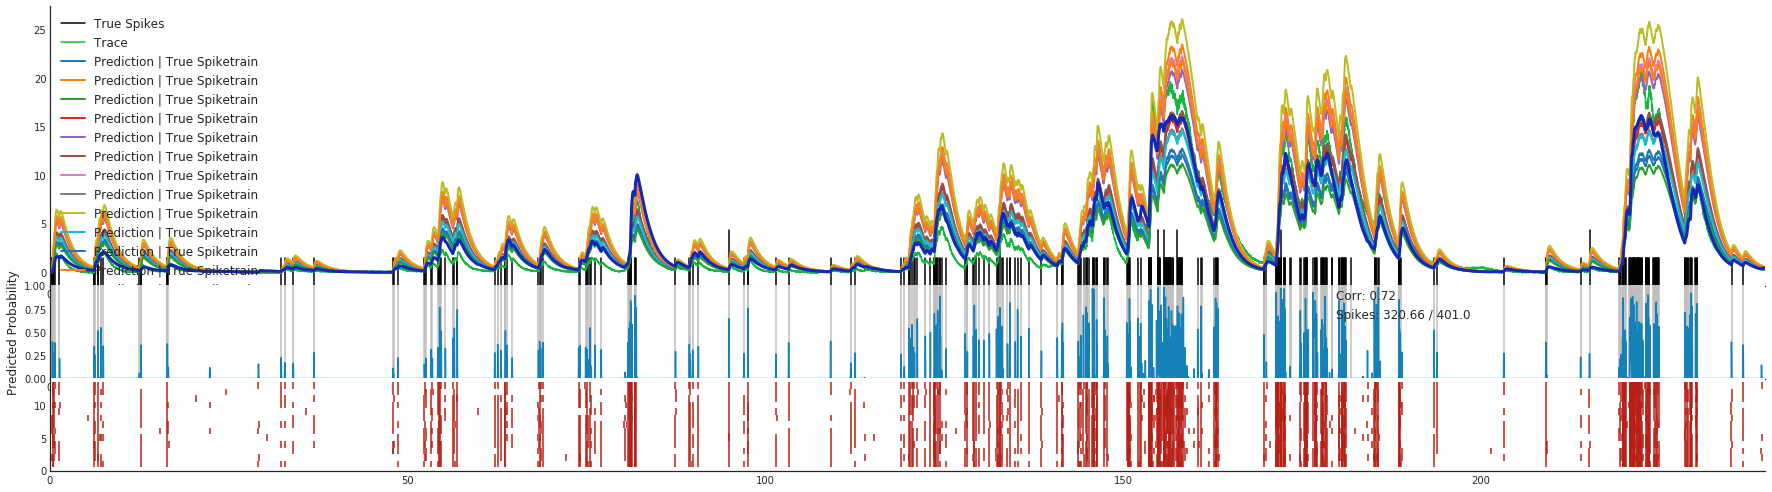

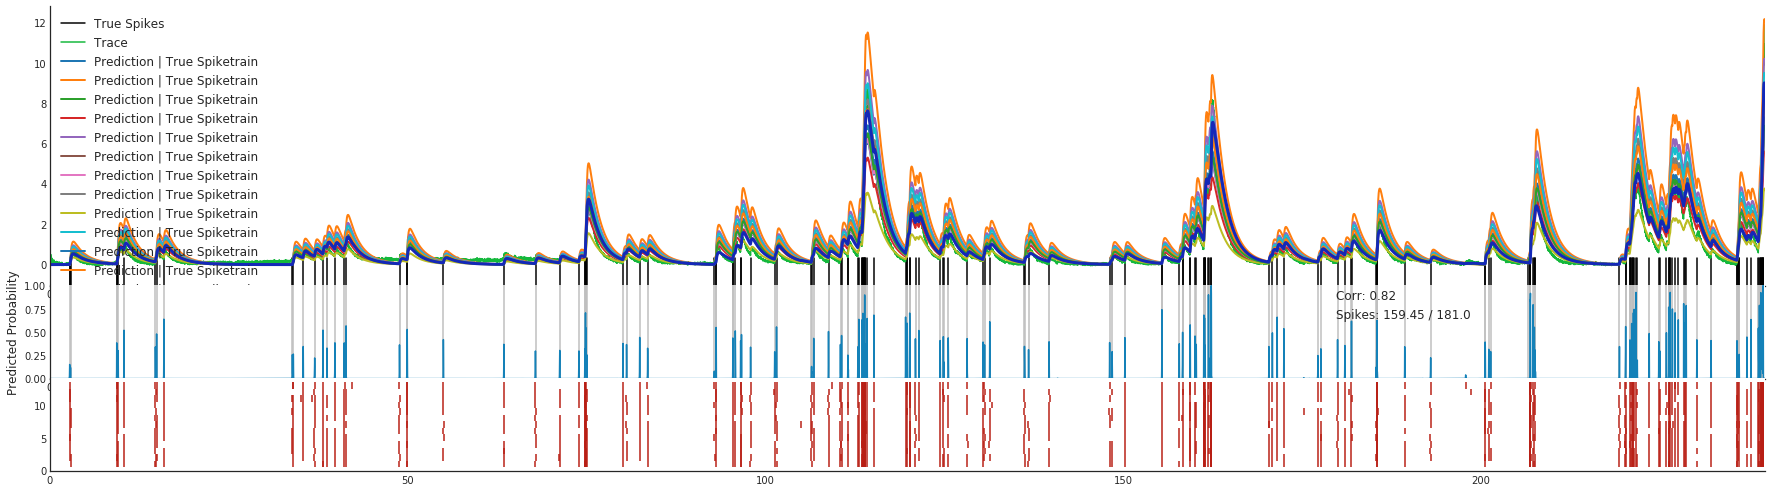

Cell  3


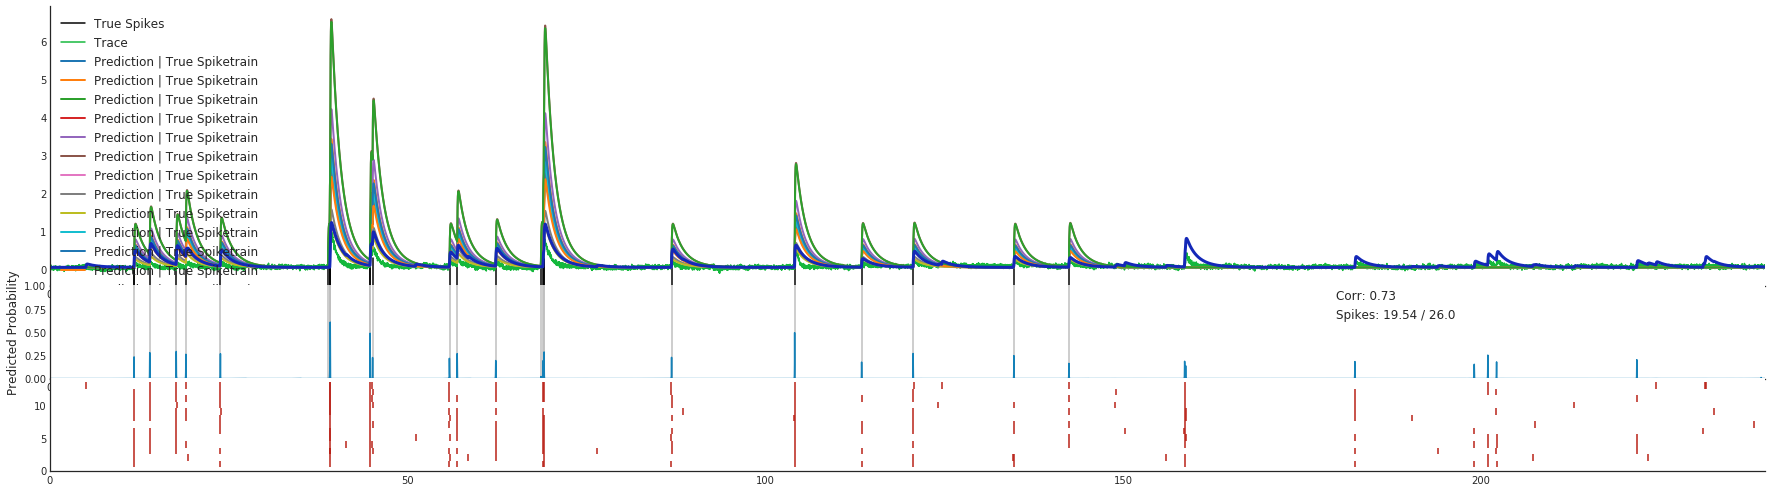

Cell  4


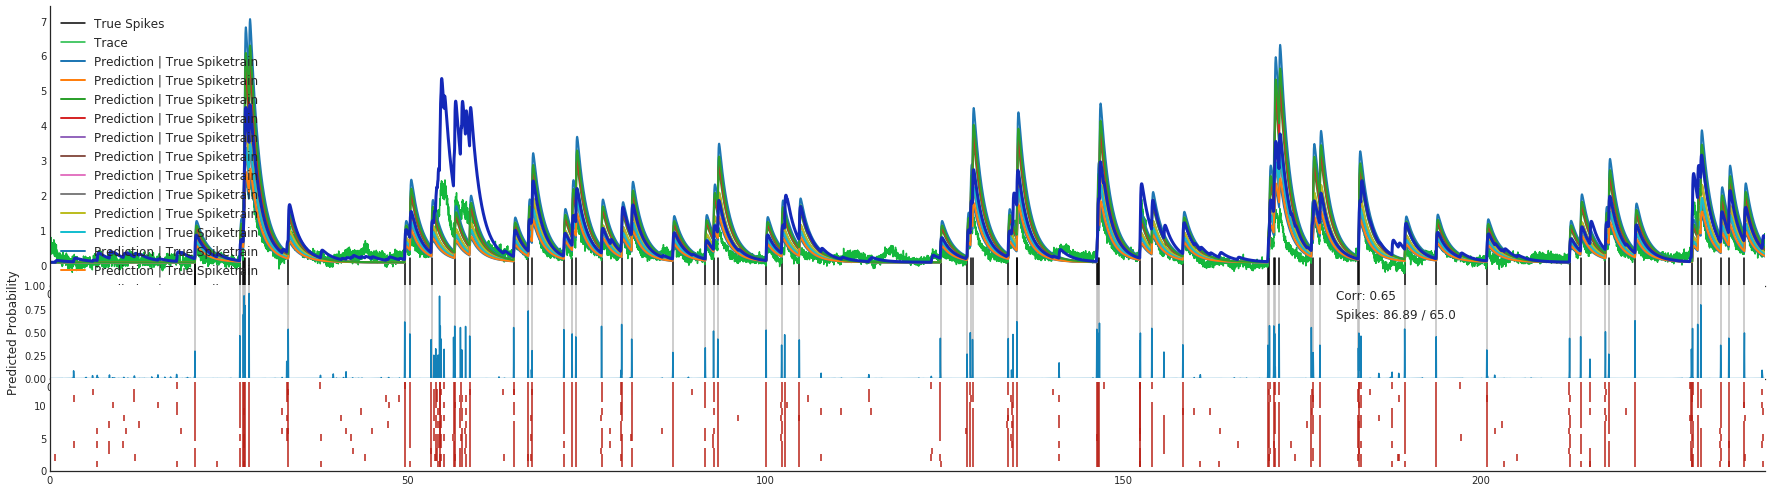

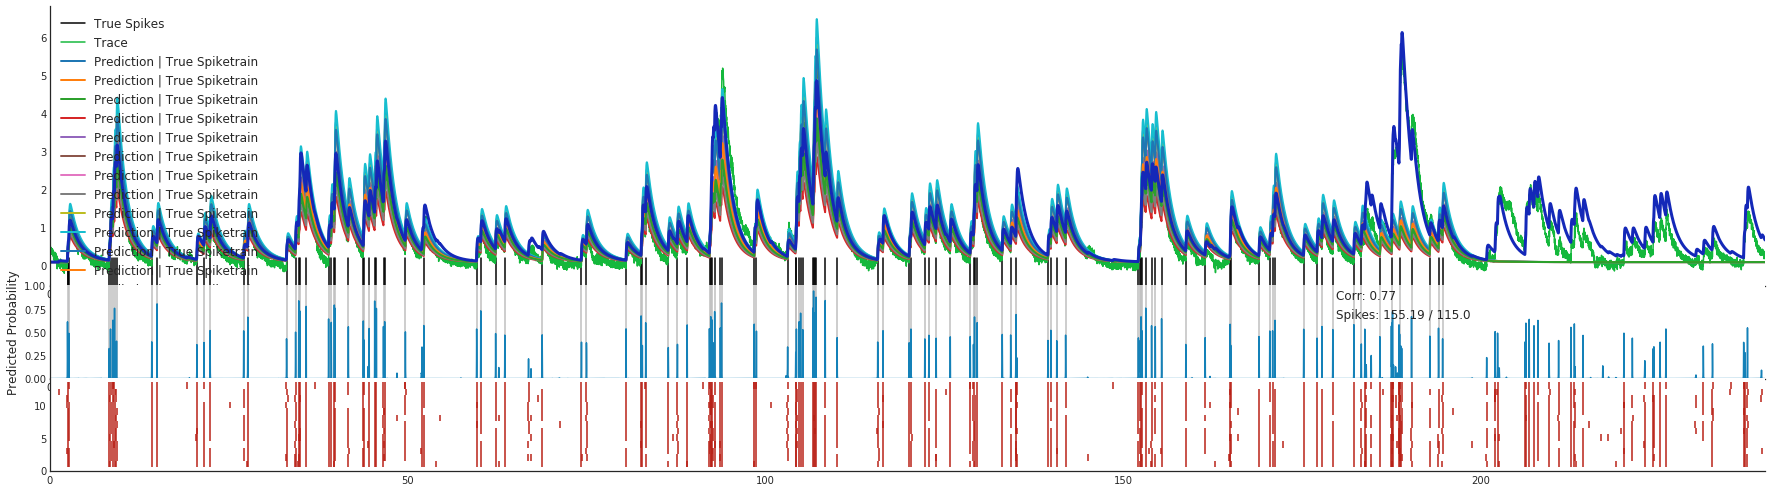

Cell  5


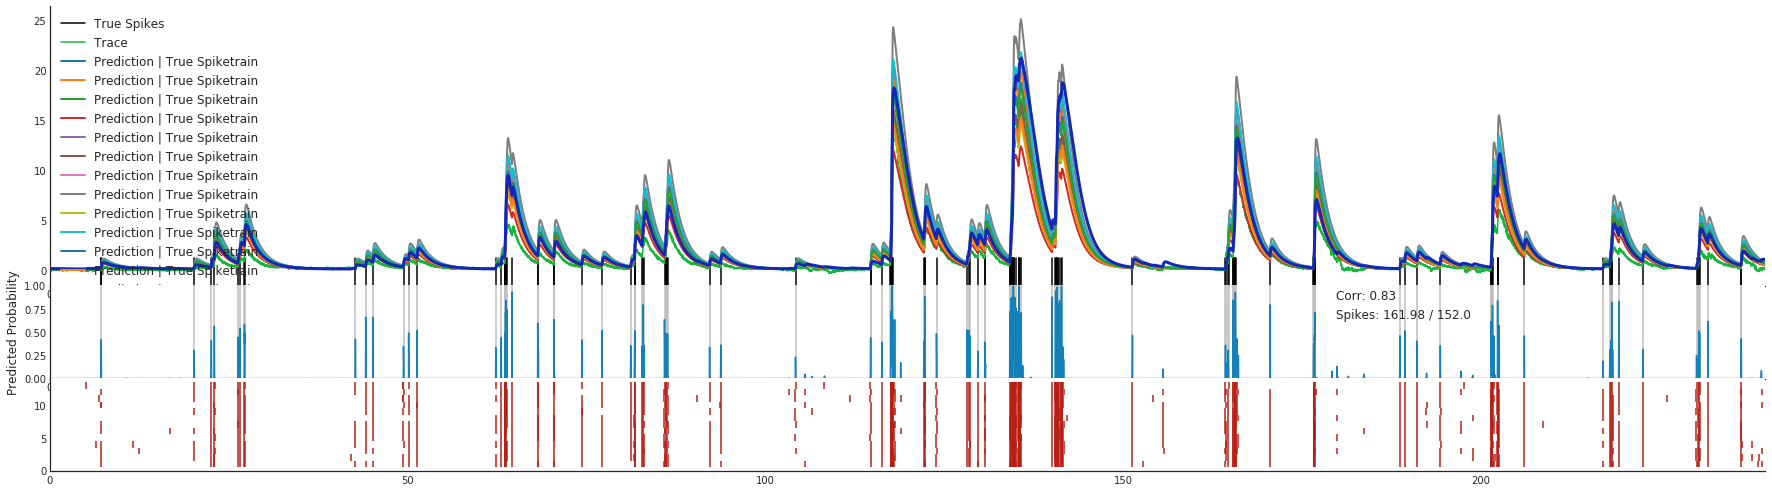

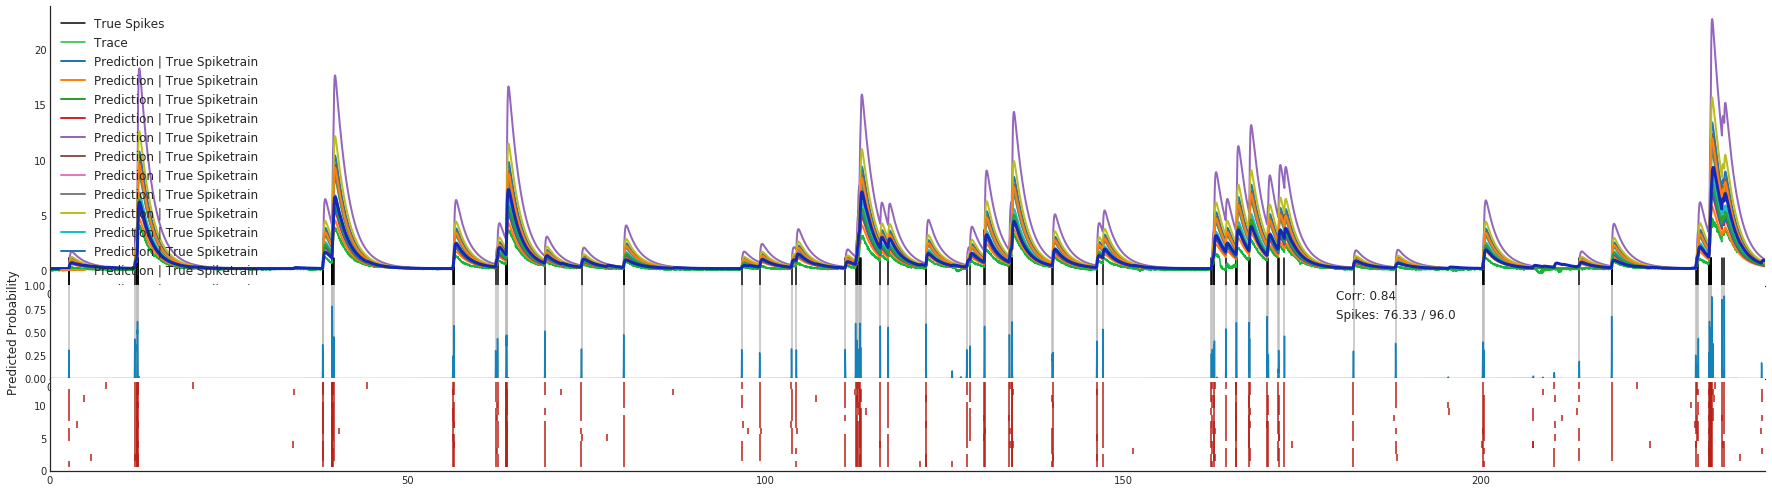

Cell  6


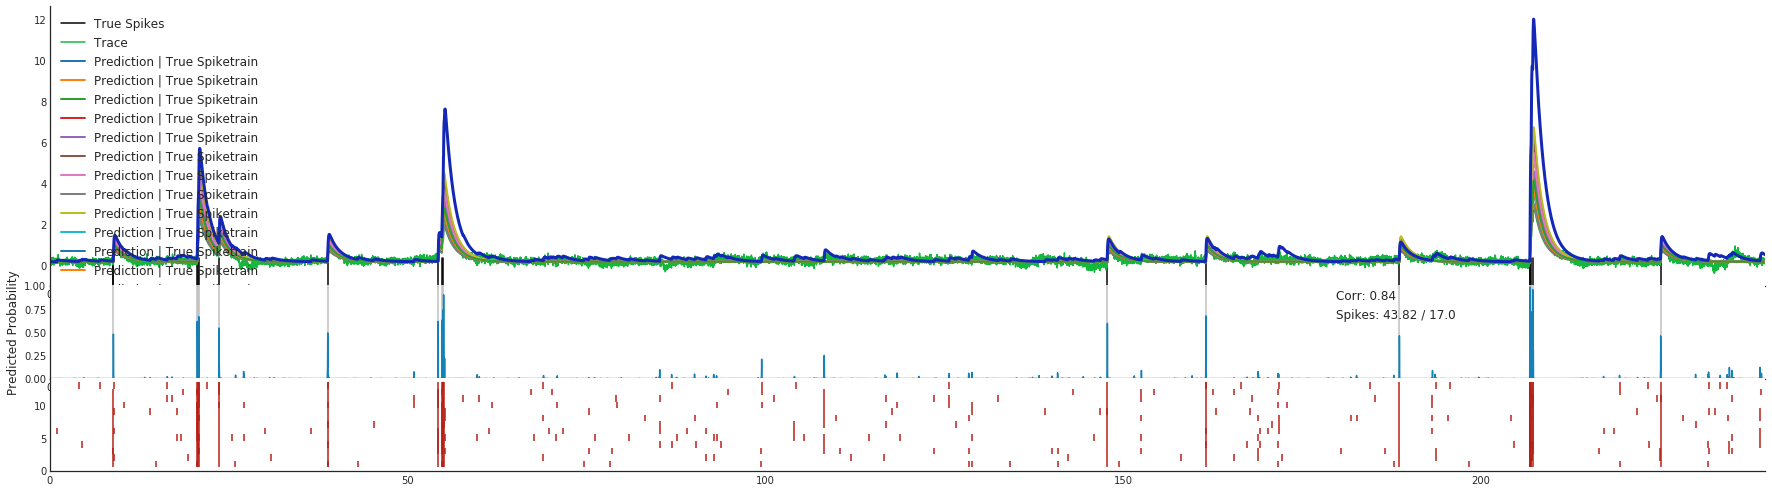

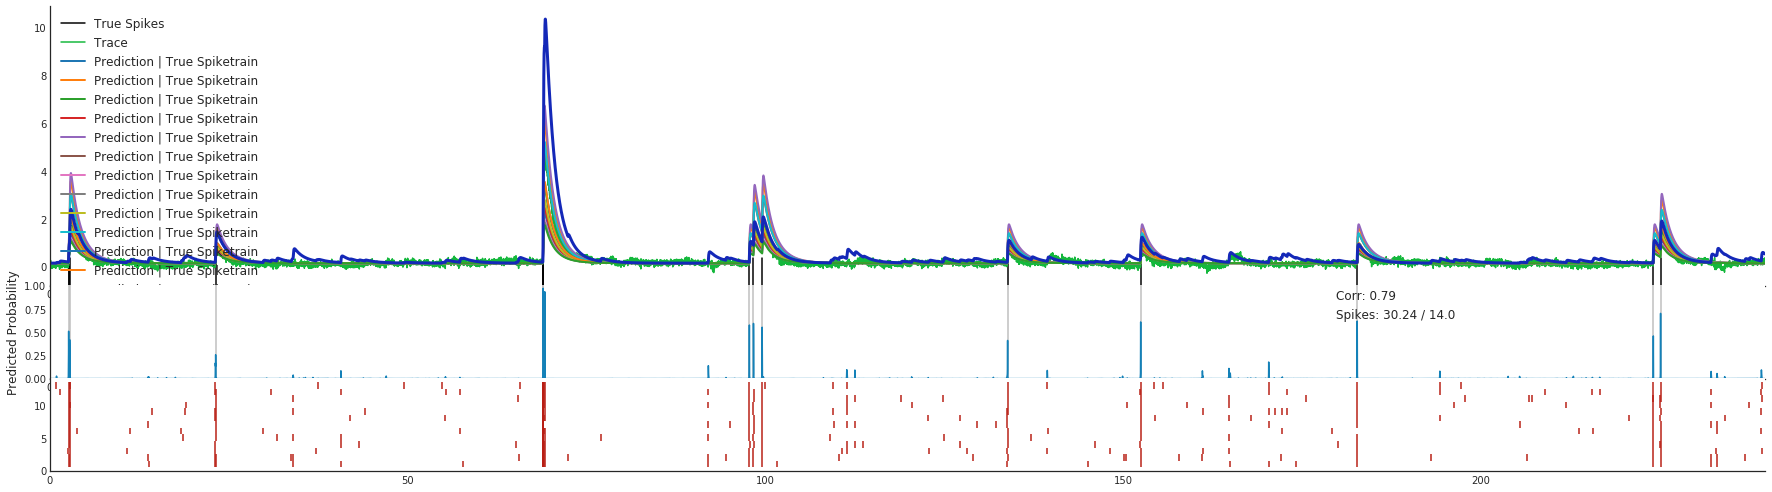

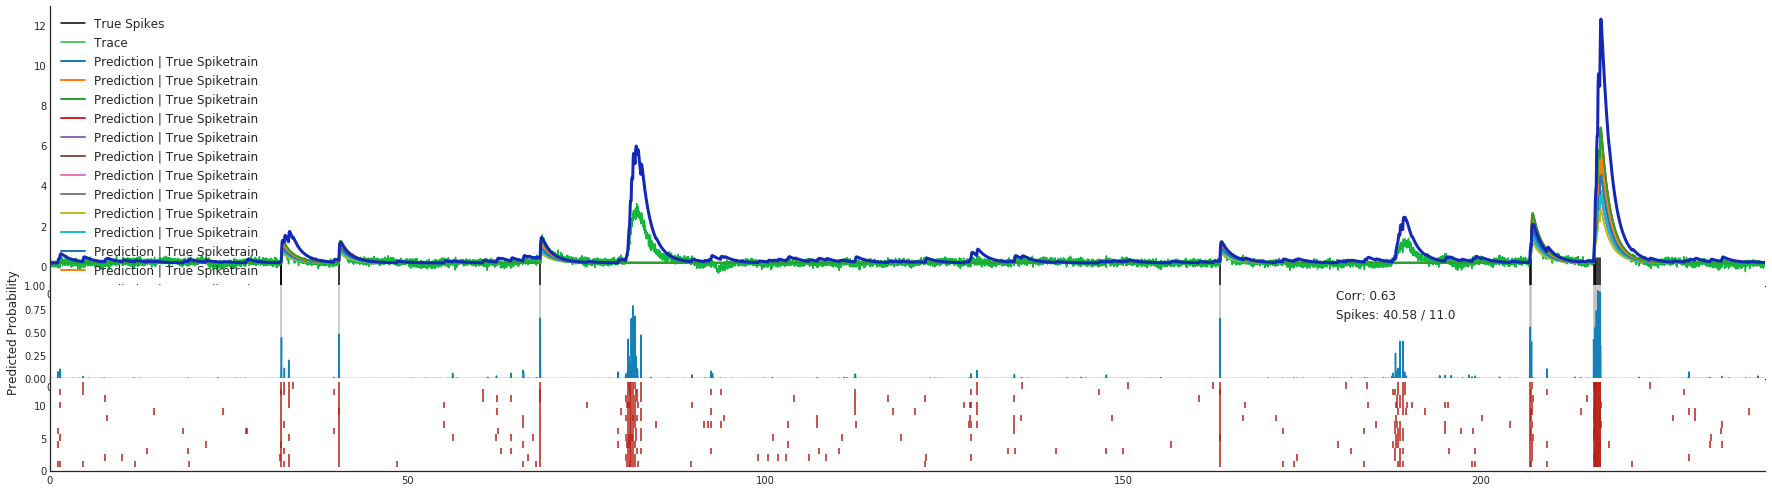

Cell  7


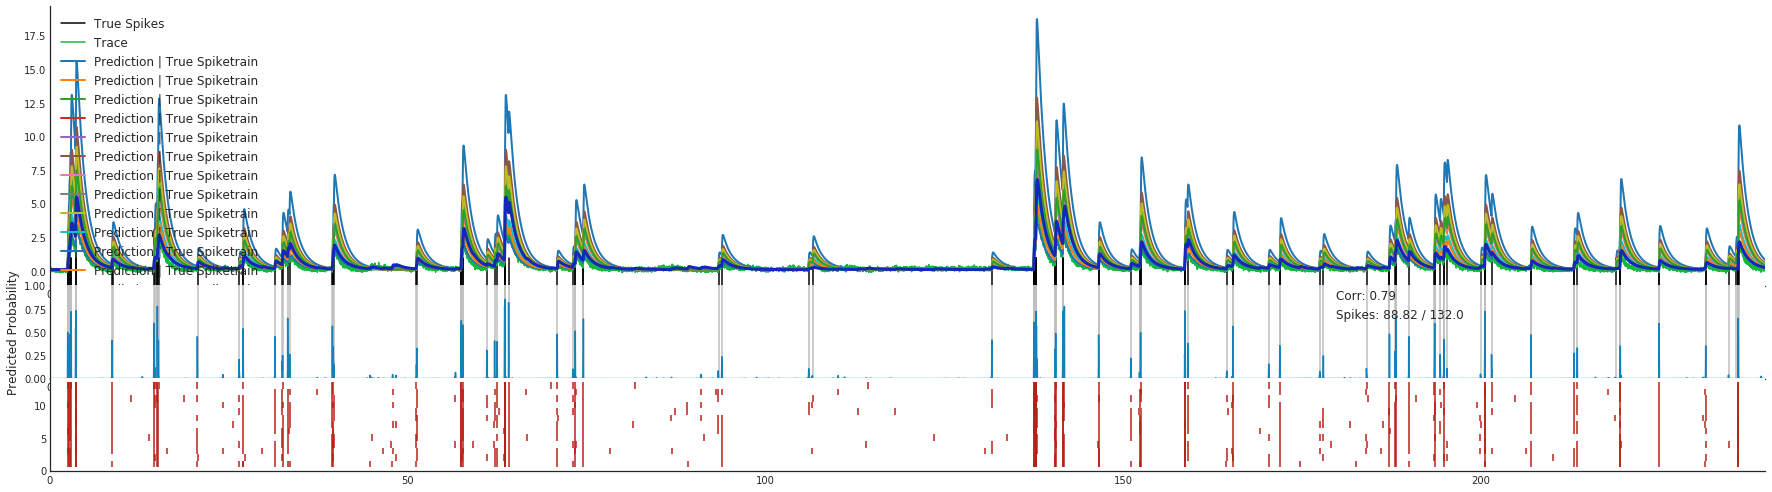

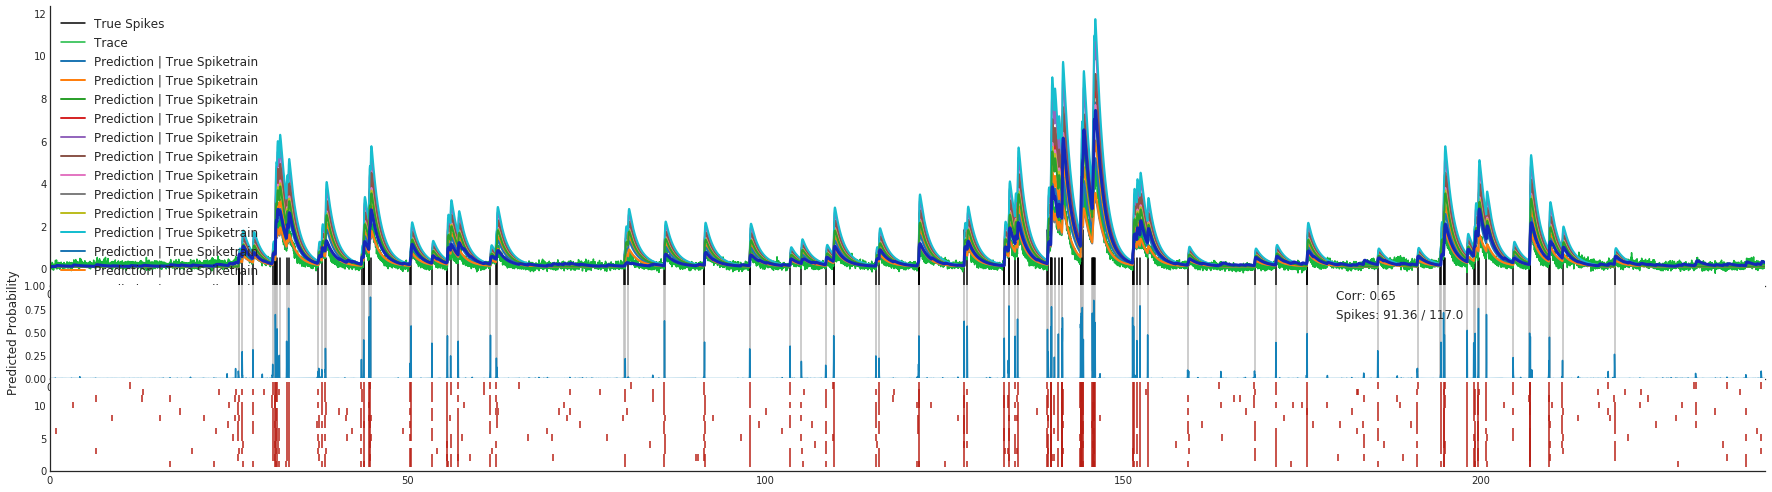

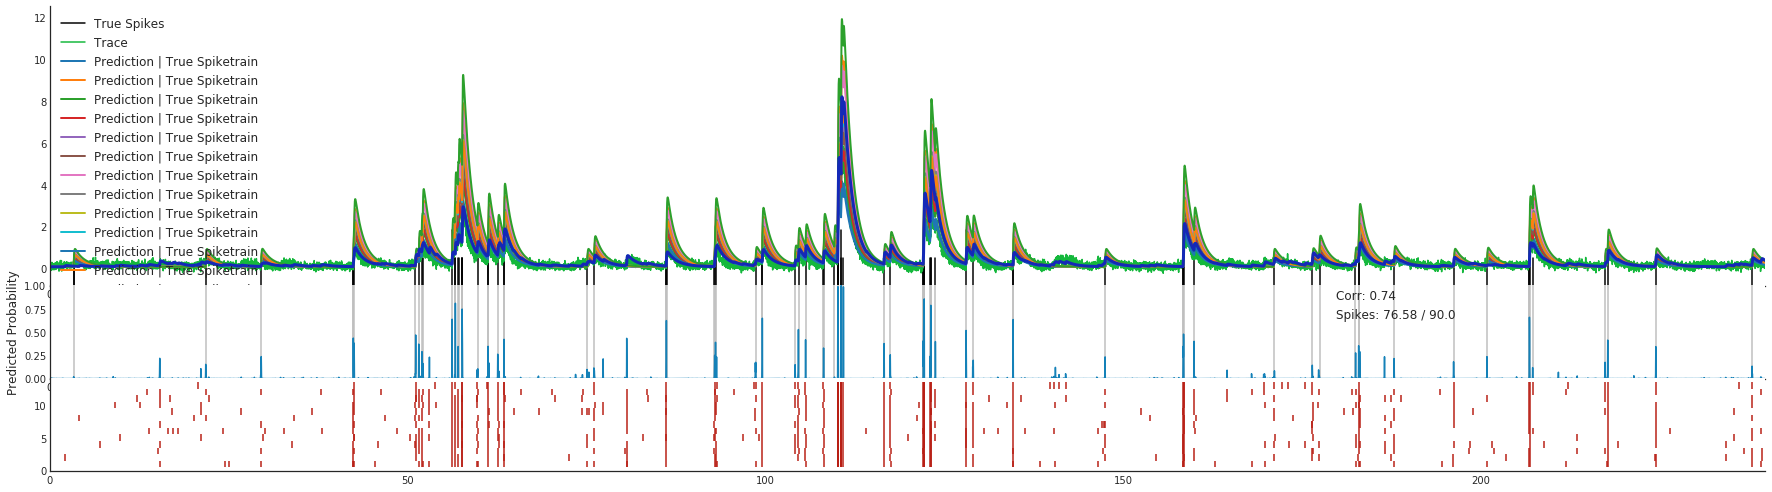

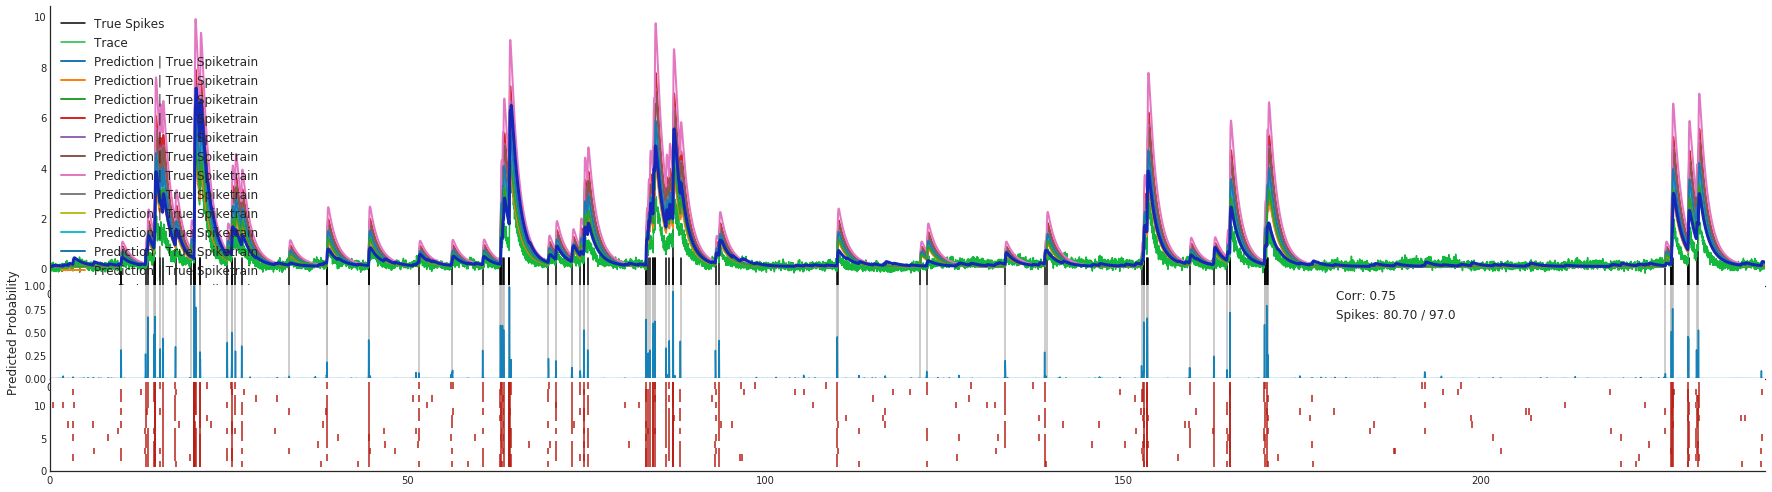

Cell  8


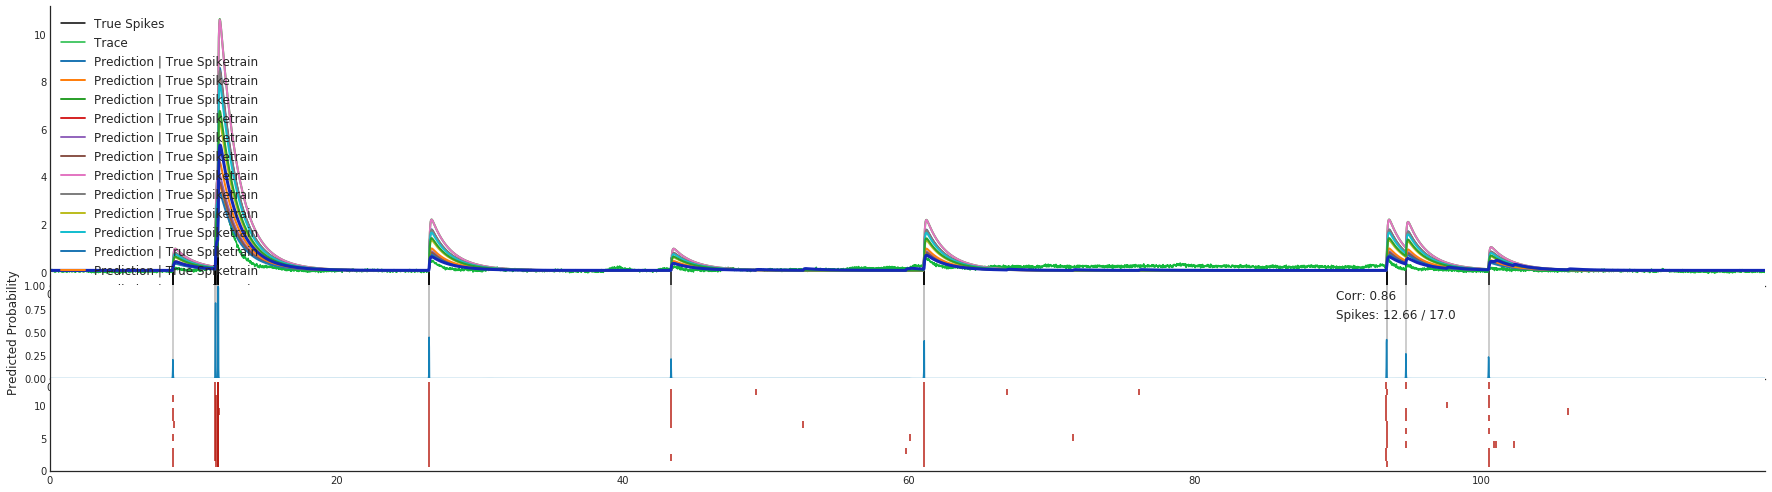

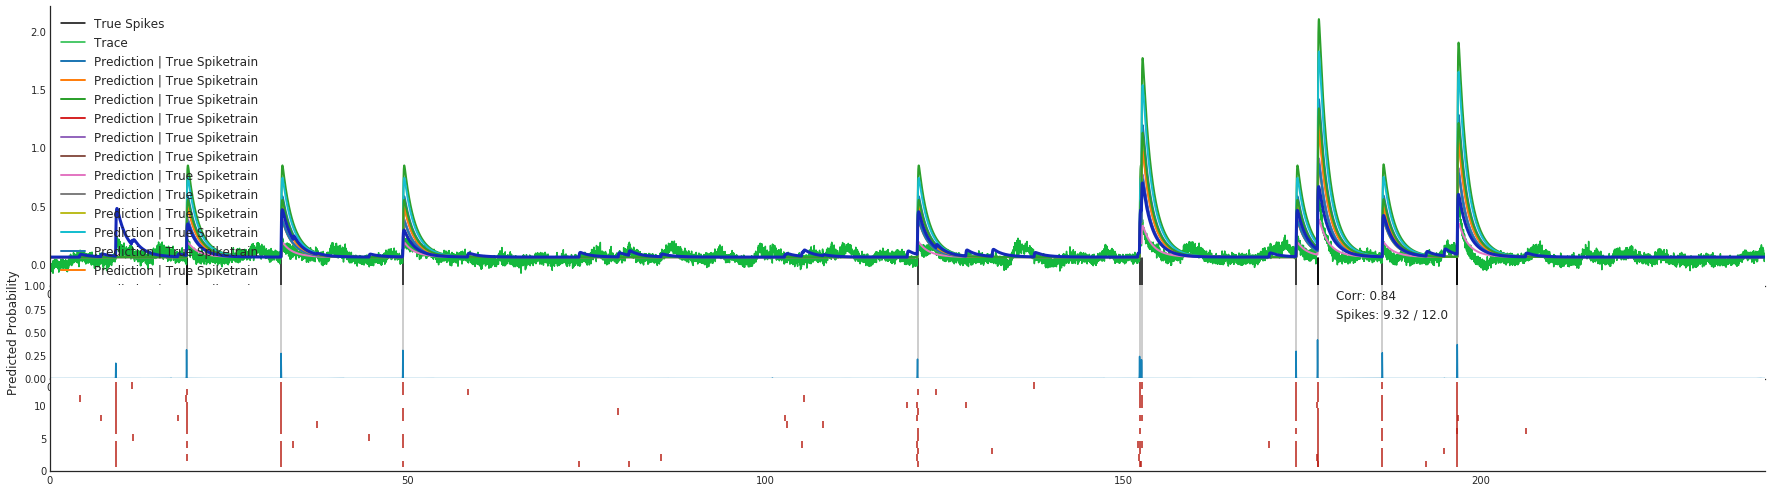

In [8]:
for c in range(9):
    print('Cell ', c)
    for t in range(len(Traces_train[c])):
        plot_preds_bl(model,data,c,trace=t,figsize=(35,7),ts=[0,20000])
        plt.show()